# A CNN Mnist Model

In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_05b_early_stopping")' FastaiNotebook_05b_early_stopping

Installing packages:
	.package(path: "/home/sgugger/git/fastai_dev/swift/FastaiNotebook_05b_early_stopping")
		FastaiNotebook_05b_early_stopping
With SwiftPM flags: []
Working in: /tmp/tmpf0i683e4/swift-install
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
Updating https://github.com/mxcl/Path.swift
Updating https://github.com/saeta/Just
Updating https://github.com/latenitesoft/NotebookExport
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swif

/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
[15/16] Merging module FastaiNotebook_02a_why_sqrt5
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swiftc: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swiftc)[16/22] Compiling FastaiNotebook_03_minibatch_training 01_matmul.swift
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
[17/22] Compiling FastaiNotebook_03_minibatch_training 03_minibatch_training.swift
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
[18

[48/49] Compiling FastaiNotebook_05b_early_stopping 01a_fastai_layers.swift
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
[49/50] Merging module FastaiNotebook_05b_early_stopping
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swiftc: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swiftc)[50/51] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
[51/52] Merging module jupyterInstalledPackages
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (r

In [ ]:
//export
import Path
import TensorFlow
#if canImport(PythonKit)
    import PythonKit
#else
    import Python
#endif


In [ ]:
import FastaiNotebook_05b_early_stopping

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Load data

In [ ]:
let data = mnistDataBunch(flat: false, bs: 512)

In [ ]:
let firstBatch = data.train.ds.first(where: { _ in true })!
let batchShape = firstBatch.xb.shape
let batchSize = batchShape.dimensions[0]
let exampleSideSize = batchShape.dimensions[1]
assert(exampleSideSize == batchShape.dimensions[2])
print("Batch size: \(batchSize)")
print("Example side size: \(exampleSideSize)")

let classCount = firstBatch.yb.shape.dimensions[0]
print("Class count: \(classCount)")

Batch size: 512
Example side size: 28
Class count: 512


In [ ]:
firstBatch.xb.shape

▿ [512, 28, 28]
  ▿ dimensions : 3 elements
    - 0 : 512
    - 1 : 28
    - 2 : 28


In [ ]:
// export
extension Learner {
    public class AddChannel: Delegate {
        public override func batchWillStart(learner: Learner) {
            learner.currentInput = learner.currentInput!.expandingShape(at: -1)
        }
    }
    
    public func makeAddChannel() -> AddChannel { return AddChannel() }
}

In [ ]:
//export 
public struct CnnModel: Layer {
    public var convs: [FAConv2D<Float>]
    public var pool = FAGlobalAvgPool2D<Float>()
    public var linear: FADense<Float>
    
    public init(channelIn: Int, nOut: Int, filters: [Int]){
        let allFilters = [channelIn] + filters
        convs = Array(0..<filters.count).map { i in
            return FAConv2D(allFilters[i], allFilters[i+1], ks: 3, stride: 2)
        }
        linear = FADense<Float>(filters.last!, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return linear(pool(convs(input)))
    }
}

In [ ]:
let model = CnnModel(channelIn: 1, nOut: 10, filters: [8, 16, 32, 32])

In [ ]:
// Test that data goes through the model as expected.
let predictions = model(firstBatch.xb.expandingShape(at: -1))
print(predictions.shape)
print(predictions[0])

[512, 10]
[ -0.11253201, -0.049103323,    0.0521518, -0.008803748,   0.08898341,  -0.10516997,
  -0.11056971,  -0.02262234,   0.12418659,  -0.04550228]


# Compare training on CPU and GPU

In [ ]:
func optFunc(_ model: CnnModel) -> SGD<CnnModel> { return SGD(for: model, learningRate: 0.4)}
func modelInit() -> CnnModel { return CnnModel(channelIn: 1, nOut: 10, filters: [8, 16, 32, 32]) }
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                      learner.makeAddChannel()])

In [ ]:
// This happens on the GPU (if you have one and it's configured correctly).
// I tried this on a GCE 8vCPU 30GB + Tesla P100:
// - time: ~4.3s
// - nvidia-smi shows ~10% GPU-Util while this is running
time { try! learner.fit(1) }

Epoch 0: [0.6049508, 0.8066]                                                    
average: 2776.809816 ms,   min: 2776.809816 ms,   max: 2776.809816 ms      


In [ ]:
// This happens on the CPU.
// I tried this on a GCE 8vCPU 30GB + Tesla P100:
// - time: ~6.3s
// - nvidia-smi shows 0% GPU-Util while this is running
time {
    withDevice(.cpu) { try! learner.fit(1) }
}

Epoch 0: [0.35809684, 0.8958]                                                  
average: 2826.306001 ms,   min: 2826.306001 ms,   max: 2826.306001 ms      


# Collect Layer Activation Statistics

In [ ]:
class ActivationStatsHook {
    var means: [Float] = []
    var stds: [Float] = []    
    func update(_ act: TF) {
        means.append(act.mean().scalarized())
        stds.append (act.std() .scalarized())
    }
}

In [ ]:
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                      learner.makeAddChannel()])

In [ ]:
var statHooks: [ActivationStatsHook] = (0..<learner.model.convs.count).map { i in 
    var stat = ActivationStatsHook()
    learner.model.convs[i].addDelegate(stat.update)
    return stat
}

In [ ]:
// This LayerDelegate stuff slows it down to ~6s/epoch.
time { try! learner.fit(2) }

Epoch 0: [0.8282108, 0.7728]                                                   
Epoch 1: [0.4538878, 0.8653]                                                   
average: 3422.217542 ms,   min: 3422.217542 ms,   max: 3422.217542 ms      


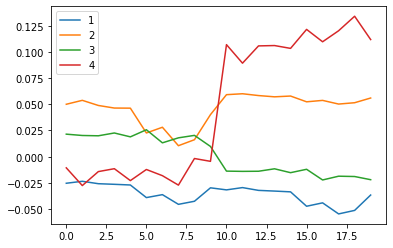

None


In [ ]:
for stat in statHooks {
    plt.plot(stat.means)
}
plt.legend(Array(1...statHooks.count))
plt.show()

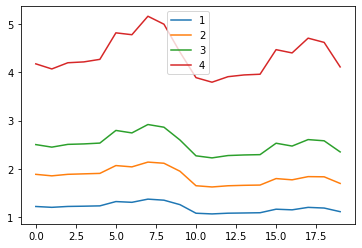

None


In [ ]:
for stat in statHooks {
    plt.plot(stat.stds)
}
plt.legend(Array(1...statHooks.count))
plt.show()

## Export

In [ ]:
import NotebookExport
let exporter = NotebookExport(Path.cwd/"06_cuda.ipynb")
print(exporter.export(usingPrefix: "FastaiNotebook_"))

success
